<div style="text-align:right"><i>Peter Norvig<br>May 2023</div>
    
# Wei-Hwa's Diamond-Buying Game 

Puzzle master [**Wei-Hwa Huang**](https://en.wikipedia.org/wiki/Wei-Hwa_Huang) poses this problem (reworded by me for clarification): 
    
> You are playing a game where a merchant has a stockpile of bags to sell. Each bag contains an unknown number of diamonds.  You can **buy a random bag** for 12 coins, look in the bag to see how many diamonds there are, and immediately decide whether to **keep it** or **sell it back** for 11 coins.  You can also **peek** at as many random bags as you want, for free,  but without the option to buy (each bag is mixed back into the stockpile after you peek at it). What is a good **strategy** for **maximizing** the number of diamonds in the bags you keep?
    
# How I think about this problem
    
These are the main concepts:
    
- **Strategy**: In general, a strategy for a game is a policy for choosing an action, in each possible situation. 
- **Actions**: The actions are to peek at or buy a bag, and after buying, to keep the bag or sell it back. 
- **Situations**: A situation consists of the number of coins you have, the number of diamonds in the bag you just bought, and what you have learned from peeking. (The number of diamonds you already have has no affect on how many *more* you can buy, and so is not part of the situation.)
- **No Guarantee**: No strategy can *guarantee* a maximal number of diamonds, because the number you get depends in part on random luck.
- **Expected value**: Instead of a guarantee, we can evaluate a strategy by its  [**expected value**](https://en.wikipedia.org/wiki/Expected_value): the expected number of diamonds obtained starting from a given situation, averaged over all possible random selections of bags from the stockpile.
- **Rationality**: Some philosophers and economists equate maximizing expected value with "[**rationality**](https://plato.stanford.edu/entries/rationality-normative-utility/)" or "doing the right thing."
- **Good strategy**: Here's what a good strategy should do in various situations:
    - Peek first. If you're going to do *K* peeks eventually, it is always best to do them all first, so they can inform your future keep/sell choices.
    - With fewer than 12 coins, nothing can be bought; the game is over.
    - With 12 coins, buy a bag and keep it no matter what, because selling it back would not yield enough coins to buy another bag. 
    - With 13 coins, buy a bag. Suppose it has *d* diamonds. Keep it if you think *d* is more than you'd get from selling it back and buying another. In other words, keep it if it is above the mean bag value you estimated from peeking.
    - With 14 coins or more you have to think ahead, considering the expected value of keeping or selling on this turn, as well as on subsequent turns.
- **Uniform distribution**: Each bag in the stockpile is equally likely to be randomly selected.
- **Probability distribution**: Both the stockpile, and our collection of peeks at the stockpile, can be  represented as a [**discrete probability distribution**](https://en.wikipedia.org/wiki/Probability_distribution#Discrete_probability_distribution) containing all the numbers of diamonds in the bags.  For example, if there are five bags in the stockpile with 108, 92, 108, 100, and 92 diamonds, respectively, then each of the five is equally likely to be chosen, and the probability of choosing a bag with 108 diamonds is 2/5.
- **Stockpile**: By default, I'll say a stockpile is 10,000 bags with mean 100 diamonds, and a player peeks at 1,000 bags. (That should be enough.)
- A **heuristic strategy** uses a guideline such as "keep all bags that are above the mean number of diamonds."
- The **optimal strategy** says to first do a large number of peeks to get a very close approximation of the distribution of the stockpile, then start buying bags and always choose the action (keep or sell) that maximizes the expected value. That may sound trivial or circular: "the best strategy is to make the best choice." But we will see that it is actually neither trivial nor circular; we will implement it and show that it works.  
    
Those are the main concepts; now it is time to implement them.
    
# Imports and constants
    
Let's get these out of the way first: imports of necessary modules, and some constants about the bags: the price, in coins, for buying or selling back a bag; the mean number of diamonds per bag in the stockpile (which I arbitrarily set to 100); the default number of bags in the merchant's stockpile, and the default number of peeks taken.

In [1]:
from typing     import *
from statistics import mean, stdev
import matplotlib.pyplot as plt
import functools
import random

BUY  = 12     # How many coins a bag costs
SELL = 11     # How many coins you get from selling a bag back
MEAN = 100    # Average number of diamonds in a bag
N    = 10_000 # Default number of bags in the merchant's stockpile
K    = 1_000  # Default number of peeks at the stockpile

cache = functools.lru_cache(None) # Decorator

# Discrete probability distribution
    
A discrete probability distribution keeps a count of how many times each value occurred. Python's `Counter` class is appropriate for this, and I will make a subclass of `Counter` called `ProbDist`. If `P` is a `ProbDist` of the number of diamonds in bags, then `P[d]` is the number of bags that contain exactly `d` diamonds. I will add a few additional things to the `ProbDist` class for convenience:
- It will be *hashable*, so that it can be passed to a function that has a `cache` decorator. Caching is crucial for efficiency.
- The attributes `P.n, P.μ, P.σ` will give the total count, mean, and standard deviation of the values in `P`, respectively.
- `P(d)` will give the *probability* of `d` diamonds. This is equal to `P[d] / P.n`.
- The attribute `P.kind` will be a string describing where the values came from. For documentation only.
- The `__str__` method will give an informative description of the distribution (showing the attributes).

In [2]:
class Hashable:
    """A mixin for classes that want to be hashable and for which equality is object identity."""
    def __hash__(self): return id(self)
    def __eq__(self, other): return self is other

class ProbDist(Hashable, Counter):
    """A discrete probability distribution, mapping values to probabilities."""
    def __init__(self, arg: Union[Iterable, Mapping], kind='ProbDist'):
        "`arg` can be either an iterable of values, or a {val: count} dict, same as with `Counter`."
        super().__init__(arg)
        values = list(self.elements())
        self.n, self.μ, self.σ, self.kind = len(values), mean(values), stdev(values), kind
    def __call__(self, value) -> float: return self[value] / self.n
    def __str__(self) -> str: return f'{self.kind}[μ={self.μ:.1f}, σ={self.σ:.1f}, n={self.n:,d}]'

Here's an example of building a probability distribution, `P`, from five values, and making some assertions about it:

In [3]:
P = ProbDist([108, 92, 108, 100, 92])
assert P[108]  == 2   # number of times 108 occurs
assert P(108)  == 2/5 # probability of 108
assert P.n     == 5   # total number of samples in the distribution
assert P.μ     == 100 # mean of the samples
assert P.σ     == 8   # standard deviation of the samples
assert dict(P) == {108: 2, 92: 2, 100: 1} 
assert repr(P) == 'ProbDist({108: 2, 92: 2, 100: 1})'
assert str(P)  == 'ProbDist[μ=100.0, σ=8.0, n=5]'

Where do the values in a discrete probability distribution come from? 

One answer is that they can be generated by repeated calls to a function that serves as a **random variable**, returning a random value each time it is called. The function `normal` constructs a probability distributions this way; this is suitable for the merchant's stockpile. (Many other distributions besides the normal or Gaussian distribution would also be suitable.) 

In [4]:
def normal(σ, μ=MEAN, n=N) -> ProbDist:
    """A ProbDist of n non-negative integers from a Normal distribution with mean μ and standard deviation σ)."""
    values = [max(0, round(random.gauss(μ, σ))) for _ in range(n)]
    return ProbDist(values, 'normal')

Another answer is to randomly sample values from a stockpile to build a distribution that approximates the stockpile. The function `peek` does this:

In [5]:
def peek(stockpile: ProbDist, k=K) -> ProbDist:
    """A ProbDist formed by peeking at k values chosen randomly from stockpile with replacement."""
    values = random.choices(list(stockpile.elements()), k=k)
    return ProbDist(values, stockpile.kind + '_peek')

Here's an example of forming a stockpile of 10,000 bags sampled from a normal distribution with standard deviation 1 and mean 100:

In [6]:
stock1 = normal(1)
stock1

ProbDist({101: 2387,
          99: 2476,
          98: 620,
          102: 614,
          100: 3766,
          103: 64,
          97: 71,
          96: 1,
          104: 1})

In [7]:
print(stock1)

normal[μ=100.0, σ=1.1, n=10,000]


Here's a distribution formed by 1,000 peeks at the stockpile:

In [8]:
P1 = peek(stock1, 1000)
P1

ProbDist({99: 246, 100: 380, 101: 246, 102: 56, 98: 62, 103: 4, 97: 6})

In [9]:
print(P1)

normal_peek[μ=100.0, σ=1.0, n=1,000]


You can see that  `P1` does a good job of replicating the mean and standard deviation of the stockpile. 

# Strategy

A **strategy** can be implemented as a function, `strategy(c, d)`, that returns  `'keep'` if a player with `c` coins should keep a bag with `d` diamonds, and otherwise returns `'sell'`. 

That covers the keep/sell choices, but how does the strategy decide when to peek? We already said that it best to do all the peeks at first. We will introduce the idea of a **strategy maker**, a function that takes as its first argument a probability distribution formed from however many peeks you want to do, and returns a strategy function to make keep/sell choices, using knowledge already gained from the peeks.

*(Rationale for always peeking first: If there was a strategy that did a peek after a keep/sell choice, it would always be at least as good to move that peek to come first, because the information from the peek could help inform the keep/sell choice. It is also theoretically true that information from a buy could inform the decision to peek or not. But since peeks have no cost, a strategy that, when faced with the choice of peeking or not, chose always to peek, would be now worse than a strategy that made a considered choice. Thus, we ight as well do the maximum number of peeks, and move them all first.)* 

As an example heuristic strategy, I'll define a strategy maker so that, for example `cutoff_strategy(peeks, 0.95)` to return a strategy function that keeps all bags with at least 95% of the mean number of diamonds in `peeks`. The strategy also keeps a bag if selling it would not give enough coins to buy another bag. 

Note that, because I will be comparing different strategies and want to be able to tell them apart, I assign the strategies names such as  `cutoff_95`.

In [10]:
Action   = Literal['keep', 'sell']      # The two possible actions
Strategy = Callable[[int, int], Action] # strategy(coins, diamonds) -> keep | sell

def cutoff_strategy(peeks: ProbDist, ratio=1.0) -> Strategy:
    """Strategy to keep all bags with `ratio * P.μ` or more diamonds. 
    Also keep a bag if selling it back would not yield enough coins to buy another bag."""
    cutoff = ratio * peeks.μ
    def strategy(c, d) -> Action: 
        return 'keep' if (d >= cutoff or c - BUY + SELL < BUY) else 'sell'
    strategy.__name__ = f'cutoff_{round(cutoff)}'
    return strategy

Here are some examples of a cutoff strategy deciding what action to take:

In [11]:
peeks = peek(stock1, 100)                # Distribution formed from 100 peeks at the stockpile
strategy = cutoff_strategy(peeks, 0.95)  # A strategy to keep bags at least 95% as good as the mean of the peeks
assert strategy(13,  92)  == 'sell'      #  92 is below the cutoff; sell it back
assert strategy(13, 100)  == 'keep'      # 100 is above the cutoff; keep it
assert strategy(12,  50)  == 'keep'      # if we sold we couldn't buy another bag

# Expected value

I'll define $E(c, P, \textit{strategy})$ to be the expected number of diamonds that can be bought with $c$ coins, from a stockpile with distribution $P$, when the player follows the given $\textit{strategy}$. The expected value is 0 if we don't have enough coins to buy any bags, and otherwise is the probability-weighted average, over all possible bags, of the expected value of the result of either keeping or selling back the bag, depending on what the strategy says to do.  That can be written as:


$$E(c, P, \textit{strategy}) = \sum_{d \in P} P(d) \left\{ 
  \begin{array}{ l l }
    0 &  \textbf{if } c < 12 \\
    E(c - 12, P, \textit{strategy}) + d   &  \textbf{if } \textit{strategy}(c, d) = \textit{keep} \\
    E(c - 12  + 11, P, \textit{strategy}) &  \textbf{if } \textit{strategy}(c, d) = \textit{sell}
  \end{array}\right.$$
  
For complex games (like Go, as played by [AlphaGo](https://www.deepmind.com/research/highlighted-research/alphago)), a *simulation* is often the best approach to approximate $E$: play *n* random games, and report the mean score. But our game is simple enough that it is possible  to do an exact calculation, as long as we remember to cache intermediate results, so we aren't repeating the same calculations again and again:

In [12]:
@cache
def E(c: int, P: ProbDist, strategy: Strategy) -> float:
    """The expected number of diamonds that can be bought with `c` coins using `strategy`,
    when the stockpile of bags has distribution `P`.""" 
    return (0 if c < BUY else
            sum(P(d) * (E(c - BUY, P, strategy) + d 
                            if strategy(c, d) == 'keep' else 
                        E(c - BUY + SELL, P, strategy)) 
                for d in P))

# Optimal strategy

For any game, the optimal strategy is to *take the action that leads to the highest expected value.*  The strategy maker `optimal_strategy(peeks)` produces a strategy that maximizes the expected value, given the distribution of peeks:

In [13]:
def optimal_strategy(peeks: ProbDist) -> Strategy:
    """Strategy to take the action that will lead to the highest expected value."""
    def optimal(c: int, d: int) -> Action:
        return 'keep' if E(c - BUY, peeks, optimal) + d > E(c - BUY + SELL, peeks, optimal) else 'sell'
    return optimal

One subtle but important point: if we want to know the true expected value of a situation, we would call `E(c, stockpile, strategy)`. That's easy enough for us to do as outside observers of the game. But a player *in* the game does not have access to the stockpile; all they have is an *estimate* of the stockpile distribution, gained from peeks. Thus, if a player's strategy asked for `E(c, peeks, strategy)`, it would get an answer that is only an estimation of the true answer for the stockpile. We will see that usually the estimation is quite good.

Here we see the optimal strategy in action:

In [14]:
stock10 = normal(10)               # A stockpile with mean 100 and standard deviation 10
P10 = peek(stock10)                # A probability distribution formed by peeking at some bags

optimal = optimal_strategy(P10)    # The optimal strategy with respect to P10
assert 99 < P10.μ < 101            # The mean of P10 is somewhere around 100
assert optimal(13,  98) == 'sell'  # sell back because we expect about 100 on the next buy
assert optimal(13, 102) == 'keep'  # keep because we expect about 100 on the next buy
assert optimal(12,  50) == 'keep'  # keep because if we sold we couldn't buy another bag
assert optimal(23, 103) == 'sell'  # 103 is an above average bag, but we have 10 chances to do better; sell it
assert optimal(23, 115) == 'keep'  # Even with 10 more chances, it is tough to beat a value of 115

At this point we have an optimal strategy; **we've solved the problem!**

We could stop here, but I have some more questions ...

___

# Visualizing Strategies

We have defined the function `optimal_strategy`, but what **is** the optimal strategy? In exactly which situations should we keep a bag and when should we sell it back? And what's an intuitive explanation for these results? Here's some code that might lead to some understanding:

In [15]:
plt.rcParams["figure.figsize"] = (14, 6)

COINS = range(12, 121) # Range of coin values to examine

def plot_strategy(P: ProbDist, strategy, bottom=75):
    """Plot (coins, diamonds) points for which the optimal action, on P, is to sell."""
    points = [(c, d) for c in COINS for d in range(bottom, max(P) + 1) 
              if strategy(c, d) == 'sell']
    plt.scatter(*transpose(points), marker='.', label=strategy.__name__)
    decorate(title=f'When to sell back with {strategy.__name__} on {P}')
    
def decorate(title, xticks=COINS[::BUY], xlabel='coins', ylabel='diamonds'):
    """Decorate the plot with title, grid lines, ticks, and labels."""
    plt.grid(True); plt.xticks(xticks); plt.legend()
    plt.title(title); plt.xlabel(xlabel); plt.ylabel(ylabel)
    
def transpose(matrix): return zip(*matrix)

The plot below looks at situations where (on the x-axis) you have a certain number of coins before you buy a bag, and on the y-axis there turns out to be a certain number of diamonds in the bag. A blue dot means that the optimal strategy is to sell the bag back in that situation. This is the **true** optimal strategy, obtained by having exact knowledge of the stockpile, something that a player could never obtain exactly.

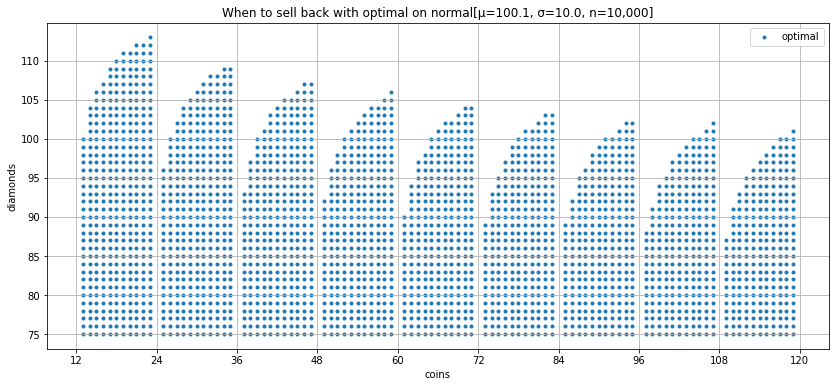

In [16]:
plot_strategy(stock10, optimal_strategy(stock10))

This plot shows that, for this stockpile, with any multiple of 12 coins there are *no* bags that should be sold back, no matter how bad the bag. For example, with 36 coins it is always better to use the 36 coins to buy and keep 3 bags than to sell one back and be left with only 2 bags. With each extra coin from 37 to 47, we can afford to be more picky, and the bag values that we will sell back increase, from 93 up to 107.  

# Evaluating strategies

It would be nice to have a **single metric** to evaluate how well a strategy does. In the quest to find such a metric, the first question is "how well a strategy does *what*?" One answer is "how well it gains diamonds, on average, starting with various numbers of coins." I'll define the function `metric` to do that. It returns the average number of diamonds per 12 coins, averaged over all starting numbers in the argument `coins`:

In [17]:
def metric(strategy, P, coins=COINS) -> float:
    """How many diamonds does the strategy get per 12 coins, averaged over all `coins`."""
    return mean(E(c, P, strategy) * BUY / c for c in coins)

Here's the metric for the optimal strategy (with 1,000 peeks) on the `stock10` stockpile:

In [18]:
optimal10 = optimal_strategy(peek(stock10, 1000))
metric(optimal10, stock10)

94.44509551435581

Since the mean of `stock10` is very close to 100, you might be surprised to see that the  optimal strategy gets less than that; does that mean something is wrong? *No*–it means that when you start with a number of coins that has a non-zero remainder mod 12, you won't be able to buy a full additional bag, and the average takes into account all remainders mod 12.  We can look at just the coins that are multiples of 12; that should give a metric very close to 100:

In [19]:
metric(optimal10, stock10, range(12, 100, 12))

100.09129999999999

And we can look at just the coins that are equal to 11 mode 12; that should give a lower value:

In [20]:
metric(optimal10, stock10, range(11, 100, 12))

74.32038141261368

# Visualizing Expected Values

The function `plot_E` below allows us to plot the expected value for a strategy as a function of the number of coins. We can compare different stockpiles, strategies, and/or numbers of peeks.  The function produces two plots: one that displays the total number of diamonds as a function of the number of coins, and one that displasy the number of diamonds per 12 coins. The flexibility in this function allows us to use it in multiple ways to make different comparisons.

In [21]:
def plot_E(stockpiles: Iterable[ProbDist], strategy_fns=[optimal_strategy], 
           ks=[K], coins=COINS, divide=False):
    """Plot the expected number of diamonds for different stockpiles, strategies, and coins."""
    for per_coins in ('', ' per 12 coins'):
        for k in ks: # k is the number of peeks
            for stock in stockpiles:
                peeks = peek(stock, k)
                for strategy_fn in strategy_fns:
                    strategy = strategy_fn(peeks)
                    diamonds = [E(c, stock, strategy) * (BUY / c if per_coins else 1)
                                for c in coins]
                    m = metric(strategy, stock, coins)
                    label = f'{m:.1f}♦︎ {strategy.__name__} {peeks}'
                    plt.plot(coins, diamonds, 'o:', label=label)
        decorate(title='Expected number of diamonds' + per_coins, xticks=coins[::12])
        plt.show()

We start with plots showing the expected number of diamonds obtained by the optimal strategy with 1,000 peeks at the `stock10` stockpile:

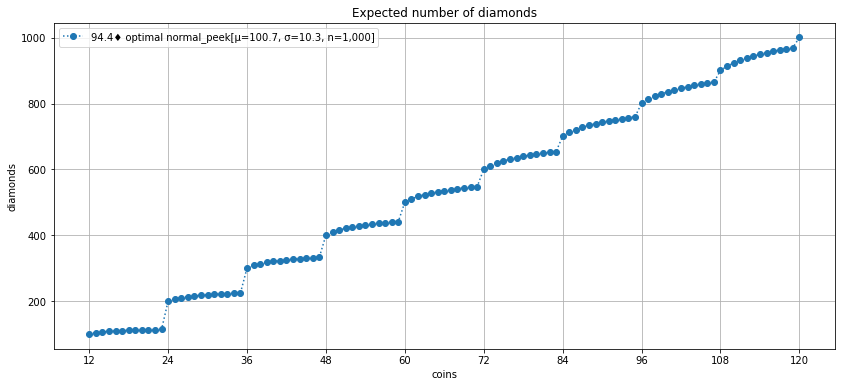

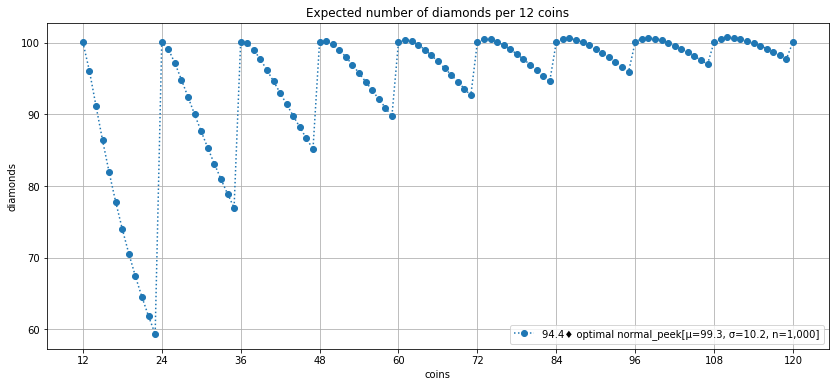

In [22]:
plot_E([stock10])

You can see that there are big jumps in expected return when the coins reach a multiple of 12, which correspond to being able to buy one more bag. Basically, the strategy with 12*b* coins is: "buy *b* bags, and keep them, no matter what, giving you an expected total of 100*b* diamonds, or 100 diamonds per 12 coins." 

In between the jumps, the plot shows gradual increases in total expected diamonds; that's because with each additional coin, we have one more opportunity to sell back a bad bag and hope to get a better one.  But the expected number of diamonds per 12 coins mostly decreases, because the return from the extra opportunities is small. We do see a few slight increases: the diamonds per 12 coins is slightly greater with 110 coins (9 bags plus two extra tries) than it is with 108 coins.

The expected value plots and the strategy plot tell the same story in two different ways: as we get more coins above a multiple of 12, we become pickier and sell back more bags; this leads to a higher expectation for the bags we keep and thus for our total expected value.

# The effect of standard deviation in the stockpile

Here is a plot comparing stockpiles with standard deviations of 1, 10, and 30. 

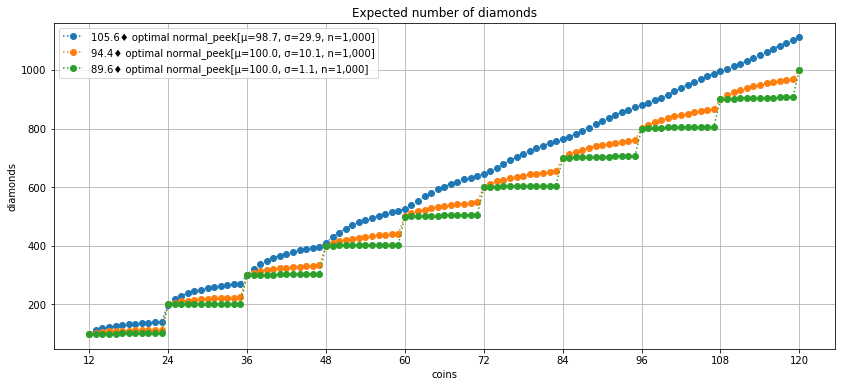

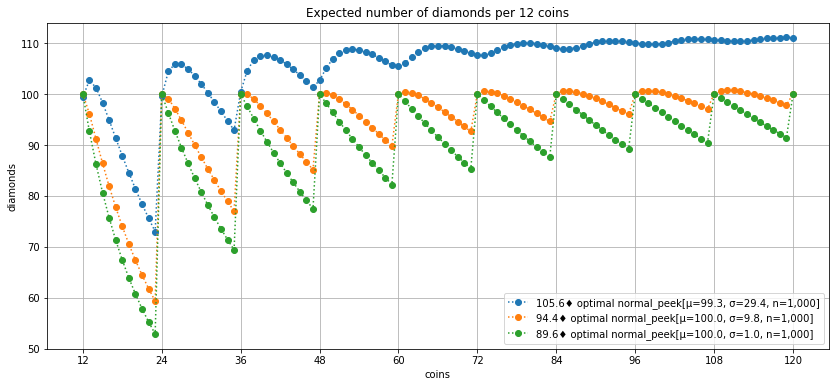

In [23]:
stock30 = normal(30) # Stockpile with standard deviation 30
plot_E([stock30, stock10, stock1])

We see that with standard deviation 1 or 10, we can't get very far above 100 diamonds per 12 coins. But with standard deviation 30, the gamble of selling a bag back and buying another starts to really pay off, and we end up with over 110 diamonds per bag. With 120 coiins we might end up with only 8 or 9 bags, not 10, but the total number of diamonds is higher because some of the bags are very good ones.

Below is the strategy plot for the optimal strategy on `stock30`. Note that with 24 or 36 coins the strategy is still to keep any bag but with 48 or more coins there are bag values that will be sold back, even though that means we will end up with one less bag.

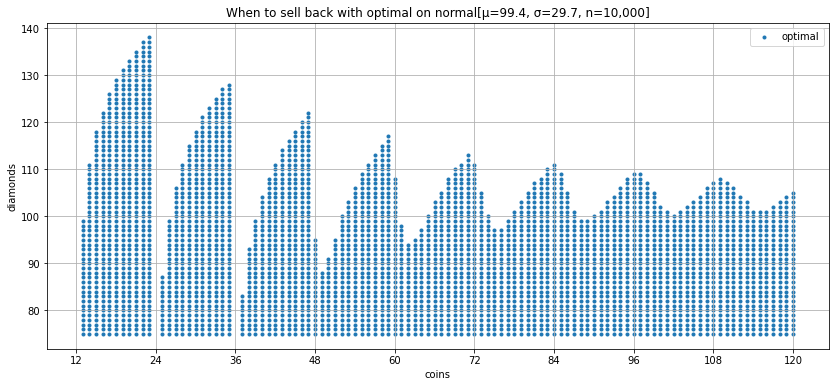

In [24]:
plot_strategy(stock30, optimal_strategy(stock30))

# The effect of distribution shape

Here I compare three probability distributions with very different shapes: a normal distribution, a uniform distribution, and a multimodal distribution that is the sum of two normal distributions. The three distributions have (roughly) the same mean and standard deviation. 

In [25]:
def uniform(μ=MEAN, semiwidth=15, n=N) -> ProbDist: 
    """A ProbDist of n integers chosen uniformly from μ ± semiwidth."""
    values = [random.randint(μ - semiwidth, μ + semiwidth) for _ in range(n)]
    return ProbDist(values, 'uniform')

def multimodal(distributions_sum: Counter) -> ProbDist:
    """A ProbDist formed from the sum of other distributions."""
    return ProbDist(distributions_sum, 'multimodal')

shapes3 = [multimodal(normal(8, 107, 6 * N) + normal(2, 90, 4 * N)),
           normal(10, n=10*N), 
           uniform(semiwidth=17, n=10*N)] 

To make the shapes smoother, I use 100,000 samples each, rather than just 10,000. Here's what they look like:

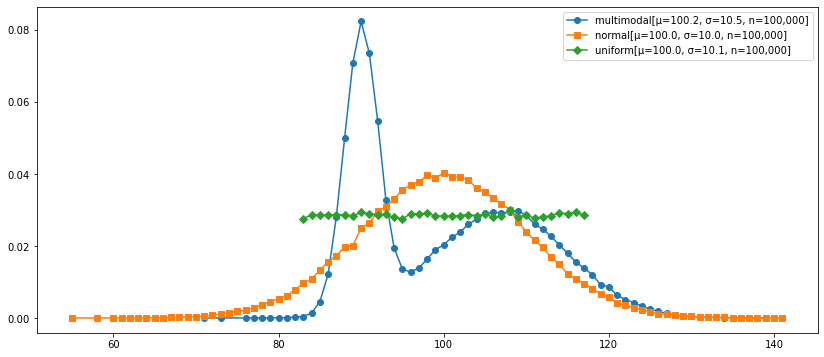

In [26]:
def plot_shapes(shapes: Iterable[ProbDist]):
    """Plot the shapes of some probability dsitributions."""
    markers = iter(5 * 'osDP')
    for P in shapes:
        X = sorted(P)
        plt.plot(X, [P(x) for x in X], next(markers) + '-', label=P)
    plt.legend()
    
plot_shapes(shapes3)

Now let's see how the expected values for the optimal strategy compare on the three shapes:

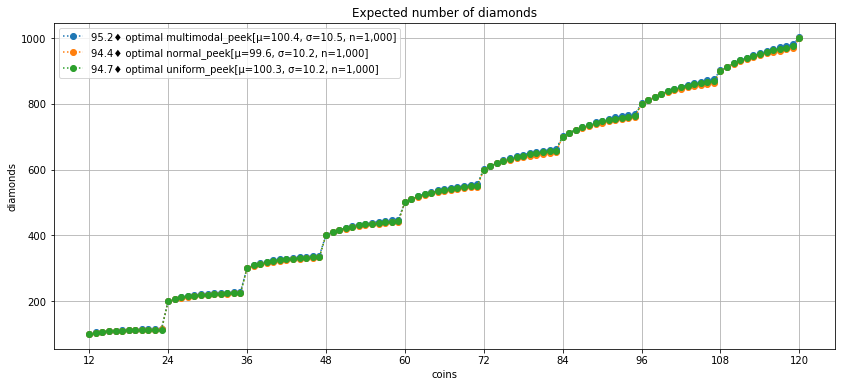

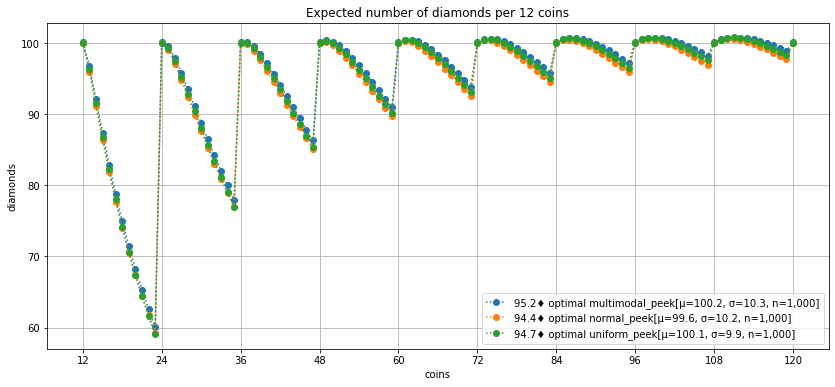

In [27]:
plot_E(shapes3)

Despite the very different shapes, the expected values are almost indistinguishable. **I found this surprising!**

## Comparing cutoff strategies

The cutoff strategy has the advantage of being simple to implement for a human player, but it is not optimal. But what is the best cutoff? And how close is it to the optimal strategy? 

First, we can find the best cutoff for any distribution by exhauastive test and comparison:

In [28]:
@cache
def best_cutoff_strategy(P, coins=COINS, cutoffs=range(70, 130)) -> Strategy:
    """The cutoff strategy that maximizes metric(strategy, P, coins)."""
    strategies = [cutoff_strategy(P, pct/100) for pct in range(101)]
    return max(strategies, key=lambda strategy: metric(strategy, P, coins))

Here are the best cutoff strategies for the `stock10` and `stock30` stockpiles, compared to the optimal strategy:

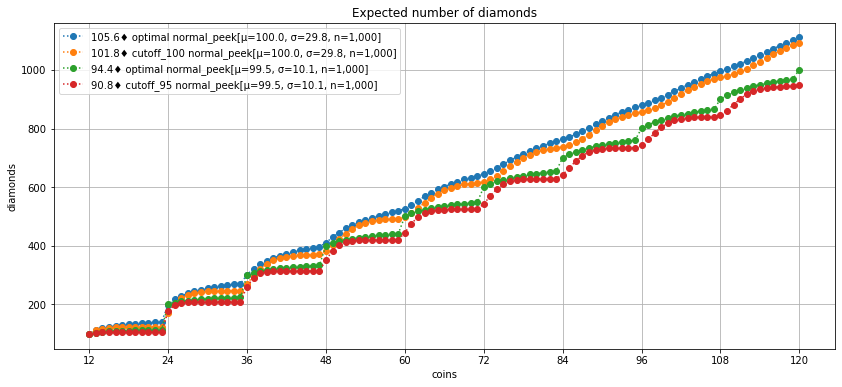

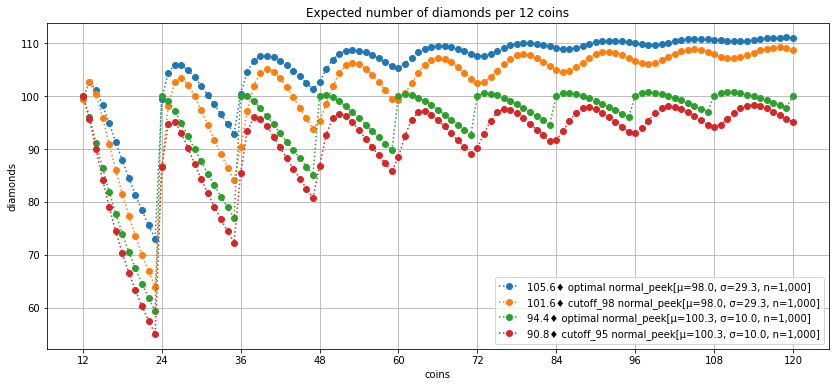

In [29]:
plot_E([stock30, stock10], [optimal_strategy, best_cutoff_strategy])

We see that on both stockpiles, the cutoff strategies lag about 4 diamonds behind the maximum expected value. 

Below we can verify that the optimal strategy is indeed better than the cutoff strategy, in every situation we have considred so far:

In [30]:
def dominates(S1: Strategy, S2: Strategy, P, coins=COINS) -> bool:
    """Is S1 always as good or better than S2?"""
    return all(E(c, P, S1) >= E(c, P, S2) for c in coins)
    
all(dominates(optimal_strategy(P), best_cutoff_strategy(P), P)
    for P in [stock1, stock30] + shapes3)

True

# How many peeks are required?

How many bags do we have to peek at to get a good sampling of the stockpile? I arbitrarily set a default of  1,000 peeks. But how much worse would we do with fewer peeks? How much better could we do with more peeks? Let's see:

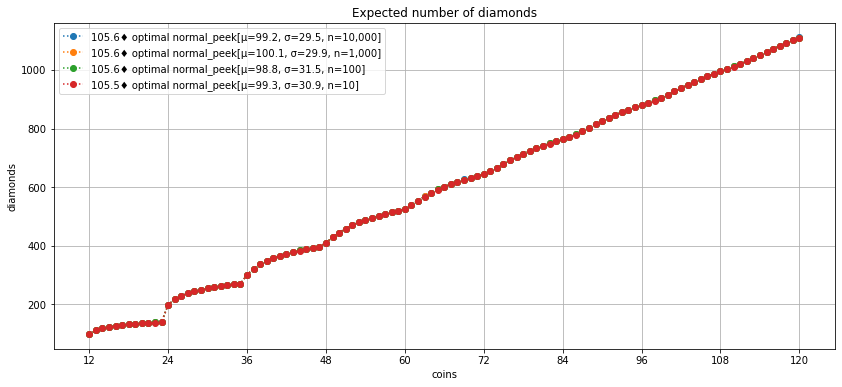

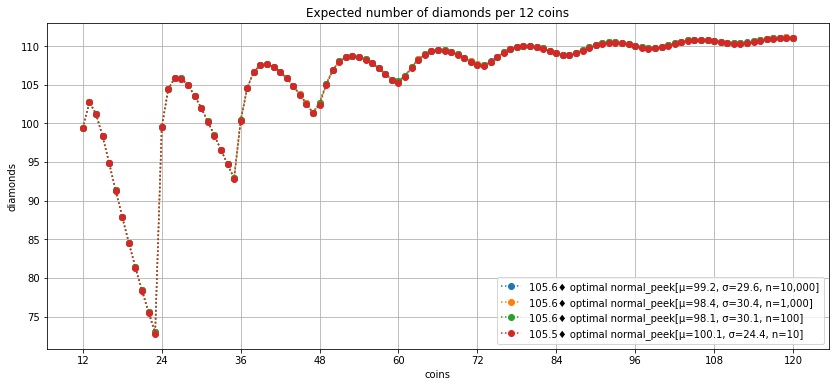

In [31]:
plot_E([stock30], ks=(10_000, 1000, 100, 10))

**I found this very surprising!** There is hardly any difference between 10,000 samples and 100 samples! We have to go all the way down to 10 samples before we see a slight dropoff in expected value. I guess this is saying that 100 samples is enough to get the general idea that the distribution has a mean of somewhere near 100, and a standard deviation somewhere near 30.

Maybe there would be more of a difference if the distribution was harder to predict. Maybe the multimodal distribution?

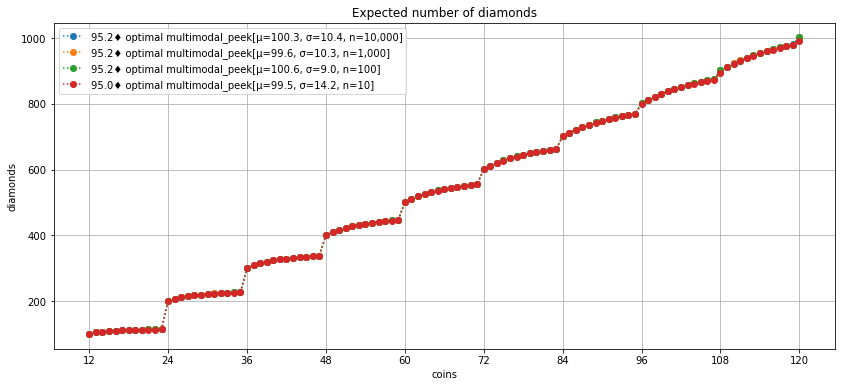

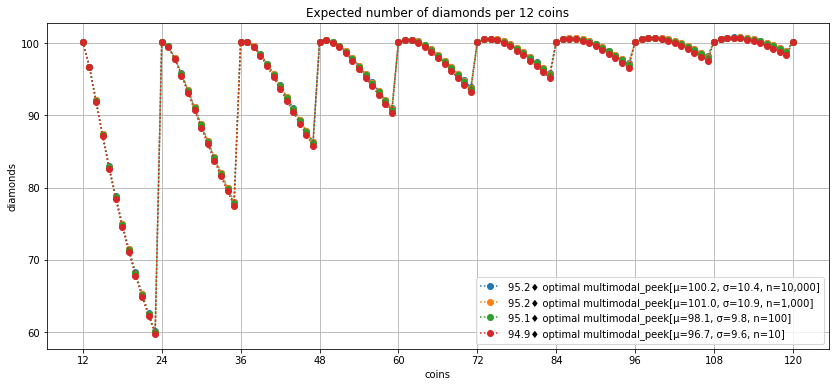

In [32]:
plot_E(shapes3[:1], ks=(10_000, 1000, 100, 10))

Not much difference; 100 samples is still almost as good as 10,000; even 10 samples does pretty well. 

Let's try a distribution that is even more skewed: the distribution from Bernoulli's [St. Petersburg Paradox](https://en.wikipedia.org/wiki/St._Petersburg_paradox), in which each value is twice as large as the previous one, but half as probable:

In [33]:
st_pete = ProbDist({18 * 2**i: 2**(10-i) for i in range(11)}, 'St_Pete')
st_pete

ProbDist({18: 1024,
          36: 512,
          72: 256,
          144: 128,
          288: 64,
          576: 32,
          1152: 16,
          2304: 8,
          4608: 4,
          9216: 2,
          18432: 1})

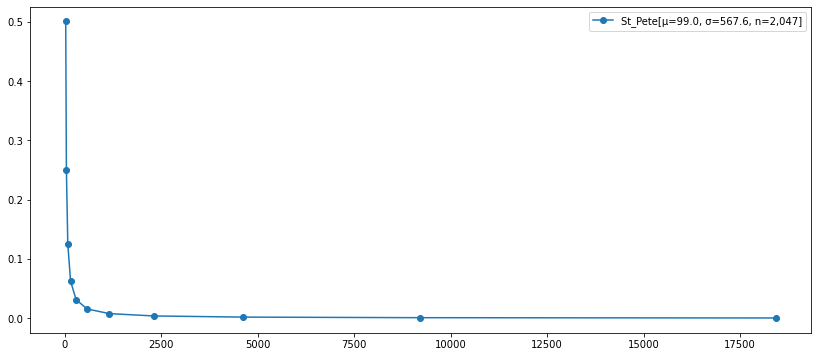

In [34]:
plot_shapes([st_pete])

I'll show the expected value when peeking 10,000 times, and when peeking at just 100 or 10 bags. There is a lot of variation from run to run, so I'll do 100 and 10 twice each, and I'll set the random seed to a value that gives a representative result (but you can rerun the cell to get different plots):

In [38]:
random.seed(99)

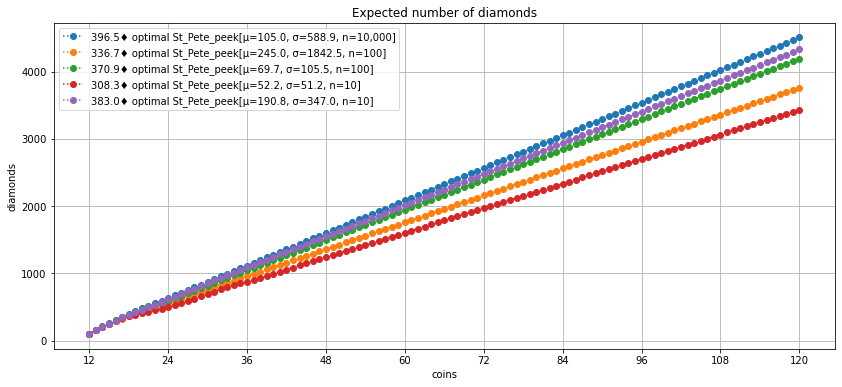

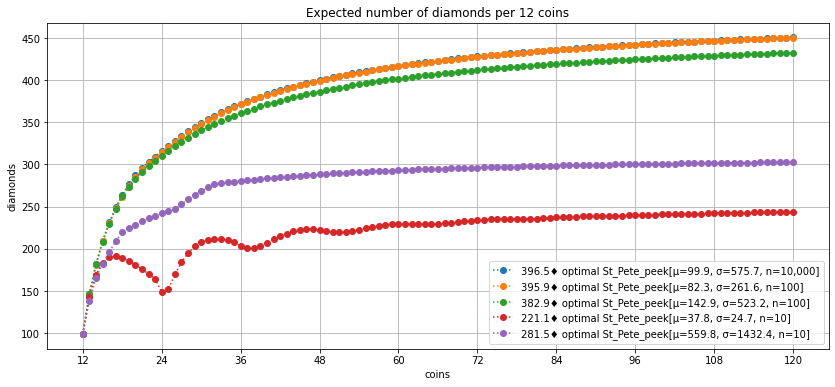

In [39]:
plot_E([st_pete], ks=(10_000, 100, 100, 10, 10))

We see that of the two runs with 100 peeks, one run is almost the same as with 10,000 peeks, and the other run is 4% worse. With 10 peeks, both runs get little more than half the possible value.

Let's see what the optimal strategy looks like for this distribution. Since the diamonds per bag go higher, I'll make the plot taller.

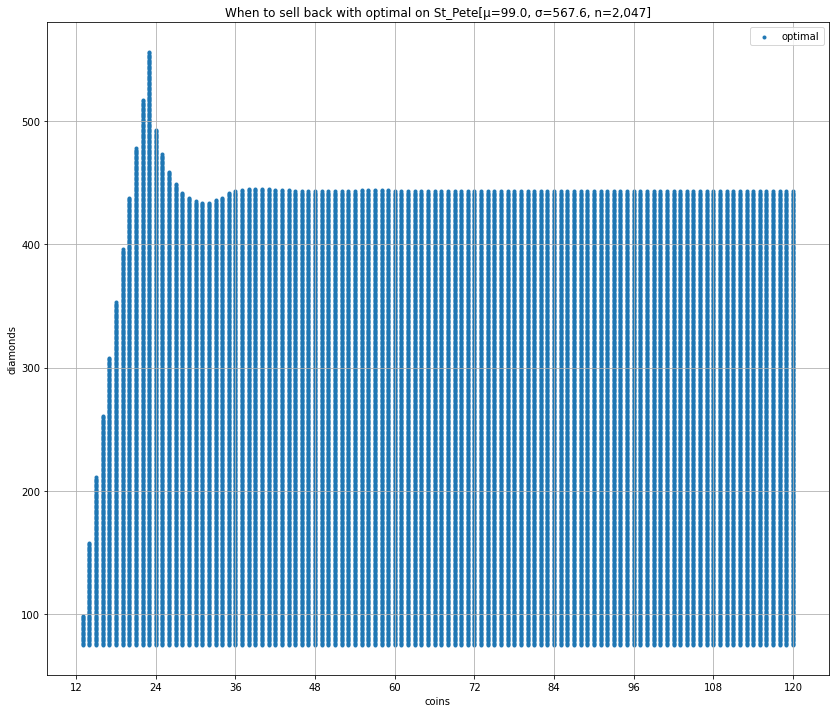

In [40]:
plt.figure(figsize=(14, 12))
plot_strategy(st_pete, optimal_strategy(st_pete)) 

I don't fully understand this plot, but it seems to be saying that up to 24 coins the shape is similar to the optimal strategy on other distributions, but once we get to 36 coins, the strategy is to sell back any bag under about 440 diamonds, regardless of how many coins are left.

# Conclusions

Two main conclusions:

- It is straightforward to implement an optimal strategy for a simple game like this. (For more complex games, it can still be straightforward to *write* the code, but infeasible to *run* it in a reasonable amount of time.) 
- It takes more work to come up with good visualizations to really understand what is going on.